<a href="https://colab.research.google.com/github/GoetheUniCV/cvproject/blob/main/models/model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup



##1.1 Python Environment
In Colab, all required packages are preinstalled and only need to be imported.

In [ ]:
!pip install ipython-autotime

In [ ]:
%load_ext autotime
import os
import sys

from google.colab import drive

from datetime import datetime

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Dropout, Activation, Add, MaxPooling2D, Conv2D, Flatten, InputLayer
from keras.models import Model, Sequential
from keras.applications import VGG19, VGG16

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

time: 5.88 s (started: 2021-02-12 14:46:55 +00:00)


##1.2 Drive Structure and Data
###1.2.1 Google Drive
Create the following directory structure in your Drive:
```
MyDrive
└── cvproject
    ├── COVID-10 Radiography Database
    │   ├── COVID-19
    │   ├── NORMAL
    │   └── Viral Pneumonia
    └── training_results

```
###1.2.2 Access COVID-19 Dataset
The directory _COVID-10 Radiography Database_ contains the dataset from Kaggle (https://www.kaggle.com/tawsifurrahman/covid19-radiography-database).

___

In [ ]:
# This mounts your Google Drive to the Colab VM.
drive.mount('/content/drive', force_remount=True)

# Foldername in your Drive where you have saved the COVID-19 data.
PROJECT_PATH = '/content/drive/MyDrive/Semestermaterial/Master/1.Semester_Master/CV/CV_Projekt/cvproject-main'
DATABASE_PATH = f'{PROJECT_PATH}/COVID-19 Radiography Database'

Mounted at /content/drive
time: 1.16 s (started: 2021-02-12 14:47:01 +00:00)


# Preprocess Images

## OPTION 1: Preprocessing Using Open-CV

In [ ]:
# check image format
test_img = cv2.imread('/content/drive/MyDrive/cvproject-main/COVID-19 Radiography Database/COVID-19/COVID-19 (1).png', cv2.IMREAD_UNCHANGED)
print(test_img.shape)

(256, 256)
time: 8.19 ms (started: 2021-02-12 12:11:06 +00:00)


In [ ]:
#https://towardsdatascience.com/loading-custom-image-dataset-for-deep-learning-models-part-1-d64fa7aaeca6
def preprocess(data_path):
  """
  Create an array containing all images and a list containing all image labels.
  """
  # For Grayscale images:
  #images_array = np.zeros((3829, 256, 256)) # number of images, images size, chanels

  # For Color images:
  images_array = np.zeros((3829, 256, 256, 3)) # number of images, images size, chanels
  labels = np.zeros((3829, 1)) # number or images

  labels_dict = {"COVID-19":0, "NORMAL":1, "Viral Pneumonia":2}

  count = 0
  for img_folder in os.listdir(data_path):  # folder with all the data (3 class folders)
    for file in os.listdir(os.path.join(data_path, img_folder)): # single class folder      
        if count % 100 == 0:
          print("Processing progress:", count, "out of", images_array.shape[0], "images.")
        # define path to image
        img_path= os.path.join(data_path, img_folder, file)

        # Load grayscale image
        #img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Load color image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) # most images are already grayscale, less data to process: faster processing and less resources necessary
        # Convert from BGR to RGB.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      
        # resize
        dsize = (256, 256)
        img=cv2.resize(img, dsize, interpolation = cv2.INTER_AREA)
        img=np.array(img)

        # normalize pixel values
        img = img.astype('float32')
        img /= 255 

        images_array[count] = img

        labels[count] = labels_dict[img_folder]
        count += 1

  print("Done.")
  return images_array, labels

time: 46.5 ms (started: 2021-02-12 12:11:06 +00:00)


In [ ]:
reload_images = False

if reload_images == True:
  X, y = preprocess(DATABASE_PATH)

  # save image and label arrays
  %cd {PROJECT_PATH}
  # save numpy array as npy file
  from numpy import save

  # save to npy file
  save('images_array.npy', X)

  y = y.astype('uint8')
  save('labels.npy', y)

time: 5.57 ms (started: 2021-02-12 12:11:06 +00:00)


## OPTION 2: Load from existing numpy array saved to file

In [ ]:
%cd {PROJECT_PATH}
# load numpy array from npy file
from numpy import load
import os.path
from keras.utils.np_utils import to_categorical  

if (os.path.isfile("images_array.npy")) and (os.path.isfile("labels.npy")): 
  # load array
  y = load('labels.npy')
  
  #categorical_labels = to_categorical(y, num_classes=3) # one hot encoding
  #del y

  X = load('images_array.npy')
else:
  print("No loadable files available!")

/content/drive/MyDrive/Semestermaterial/Master/1.Semester_Master/CV/CV_Projekt/cvproject-main
time: 2min 46s (started: 2021-02-12 14:47:07 +00:00)


# Split dataset

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# clear out RAM
del X
del y

time: 7.04 s (started: 2021-02-12 12:13:11 +00:00)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


values, value_count = np.unique(y_test, return_counts=True)
print('Distribution of classes in test set:', value_count)

(3063, 256, 256, 3)
(766, 256, 256, 3)
(3063, 1)
(766, 1)
Distribution of classes in test set: [245 269 252]
time: 22.7 ms (started: 2021-02-12 12:13:18 +00:00)


# Define Model Architecture

In [ ]:
#model_0 = VGG16(include_top=False, input_shape=(256, 256, 1)) # height, width, channels

#inputs = layers.Input(shape=(224, 224, 3))
#outputs = EfficientNetB0(include_top=False)
#model = tf.keras.Model(inputs, outputs)

#for layer in model_0.layers:
#	layer.trainable = False

#for layer in range(-20, -1):
#	model.layers[layer].trainable = True

#flatten_layer = Flatten()(model_0.layers[-1].output)
#classification_layer1 = Dense(1024, activation='relu')(flatten_layer)
#output_layer = Dense(3, activation='softmax')(classification_layer1)

#model_0 = Model(inputs=model_0.inputs, outputs=output_layer)



# Define data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  #layers.experimental.preprocessing.RandomRotation(0.2),
])
#https://www.tensorflow.org/tutorials/images/data_augmentation

# Defining the CNN.
model_1 = tf.keras.models.Sequential([
  layers.InputLayer(input_shape = (256,256, 3)),
  layers.Conv2D(64, 5, activation='relu'),
  layers.MaxPooling2D(padding='same'),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3, activation= 'softmax')
])

model_2 = tf.keras.models.Sequential([ # Luis
  layers.InputLayer(input_shape = (256,256, 3)),
  layers.Conv2D(64, 3, activation='relu'), # filters, kernel size
  layers.MaxPooling2D(padding='same'),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3, activation= 'softmax')
])

model_3 = tf.keras.models.Sequential([
  layers.Conv2D(128, 3, activation='relu'), # number of filters, kernel size
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3, activation= 'softmax')
])


model_4 = tf.keras.models.Sequential([
  layers.Conv2D(128, 3, activation='relu'), # filters, kernel size
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3, activation= 'softmax')
])

model_5 = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, activation='relu'), # filters, kernel size
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3, activation= 'softmax')
])

model_6 = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'), # filters, kernel size
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3, activation= 'softmax')
])

model_7 = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'), # filters, kernel size
  #batchnorm
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(3, activation= 'softmax')
])

model_8 = tf.keras.models.Sequential([
  data_augmentation,
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'), # filters, kernel size
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.15),
  layers.Dense(3, activation= 'softmax')
])

model_9 = tf.keras.models.Sequential([
  data_augmentation,
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'), # filters, kernel size
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(3, activation= 'softmax')
])

model = model_2


time: 9.29 s (started: 2021-02-12 12:13:18 +00:00)


#2. Model Training

In [ ]:
# Avoid overfitting, strop training if model stopped improving...
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

# Compile the model.

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model.
history=model.fit(X_train, y_train,
                  validation_split=0.2,
                  #validation_data=(X_test, y_test),
                  batch_size=32,epochs = 15)
                  #,callbacks=[early_stop])

#https://www.programiz.com/python-programming/datetime/current-time
now = datetime.now()
current_time = now.strftime("%d-%m-%Y_%H-%M-%S")

# clear out RAM in order to be able to save model
del X_train

Epoch 1/15
77/77 [==============================] - 21s 146ms/step - loss: 30.0617 - accuracy: 0.5958 - val_loss: 0.2453 - val_accuracy: 0.9054
Epoch 2/15
77/77 [==============================] - 9s 117ms/step - loss: 0.1962 - accuracy: 0.9299 - val_loss: 0.1536 - val_accuracy: 0.9396
Epoch 3/15
77/77 [==============================] - 9s 117ms/step - loss: 0.1070 - accuracy: 0.9644 - val_loss: 0.1324 - val_accuracy: 0.9511
Epoch 4/15
77/77 [==============================] - 9s 117ms/step - loss: 0.0578 - accuracy: 0.9824 - val_loss: 0.1387 - val_accuracy: 0.9462
Epoch 5/15
77/77 [==============================] - 9s 117ms/step - loss: 0.1012 - accuracy: 0.9783 - val_loss: 0.1819 - val_accuracy: 0.9347
Epoch 6/15
77/77 [==============================] - 9s 117ms/step - loss: 0.0785 - accuracy: 0.9768 - val_loss: 0.1567 - val_accuracy: 0.9445
Epoch 7/15
77/77 [==============================] - 9s 118ms/step - loss: 0.0368 - accuracy: 0.9903 - val_loss: 0.1766 - val_accuracy: 0.9462
Epoc

##2.1 Save Training History Plots

In [ ]:
MODEL_PATH = f'{PROJECT_PATH}/training_results/{current_time}'

#%cd {PROJECT_PATH}
%mkdir {MODEL_PATH}

%cd {MODEL_PATH}

/content/drive/MyDrive/Semestermaterial/Master/1.Semester_Master/CV/CV_Projekt/cvproject-main/training_results/12-02-2021_12-15-56
time: 404 ms (started: 2021-02-12 12:15:56 +00:00)


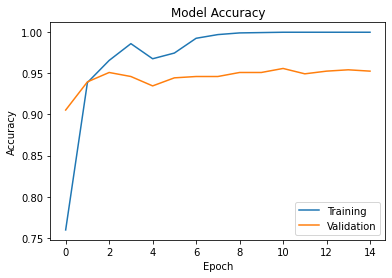

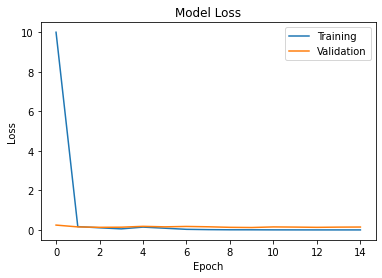

time: 457 ms (started: 2021-02-12 12:15:57 +00:00)


In [ ]:
# plot training history
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'])
#plt.show()

accuracy_name = 'train_val_accuracy' + '_' + str(current_time) + '.png'
plt.savefig(accuracy_name)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'])
#plt.show()

loss_name = 'train_val_loss' + '_' + str(current_time) + '.png'
plt.savefig(loss_name)

#3. Evaluation

In [ ]:
# Evaluate the model.
acc = (model.evaluate(X_test, y_test))[1]

24/24 [==============================] - 1s 30ms/step - loss: 0.0823 - accuracy: 0.9713
time: 1.18 s (started: 2021-02-12 12:15:57 +00:00)


##3.1 Create Confusion Matrix

In [ ]:
# Load the model which was created in the notebook model.ipynb.
#model = tf.keras.models.load_model("/content/drive/MyDrive/cvproject-main/training_results/Old/23-01-2021_19-26-01/model_23-01-2021_19-26-01.h5")

time: 552 µs (started: 2021-02-12 12:15:58 +00:00)


              precision    recall  f1-score   support

           0      0.980     0.976     0.978       245
           1      0.970     0.978     0.974       269
           2      0.964     0.960     0.962       252

    accuracy                          0.971       766
   macro avg      0.971     0.971     0.971       766
weighted avg      0.971     0.971     0.971       766



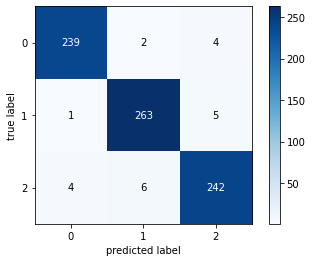

time: 1.23 s (started: 2021-02-12 12:15:58 +00:00)


In [ ]:
#https://stackoverflow.com/questions/64622210/how-to-plot-confusion-matrix-for-prefetched-dataset-in-tensorflow

y_pred = model.predict(X_test)

prediction = tf.argmax(y_pred, axis=1)
#ground_truth = tf.concat([y for x, y in test_data], axis=0) # get true labels of test dataset 

lung_conf_matrix = confusion_matrix(y_test, prediction)

class_names =  ["COVID-19","NORMAL","Viral Pneumonia"]

#http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

fig, ax = plot_confusion_matrix(conf_mat=lung_conf_matrix,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False)
                                #class_names=class_names) # funktioniert auf kaggle aber nicht auf colab... ersetzt classen indizes mit classen namen

#print("Truth:", ground_truth)
#print("Predicted:", prediction)
#print(lung_conf_matrix)

conf_name = 'conf_matrix' + '_' + str(current_time) + '.png'
plt.savefig(conf_name)
#plt.show()

from sklearn import metrics
print(metrics.classification_report(y_test, prediction, digits=3))# target_names=class_names))

##3.2 Save Performance Metrics

In [ ]:
%cd {PROJECT_PATH}/training_results

from sklearn import metrics

def print_to_file(summary):
    with open('results.txt','a') as txt_file:
        print(summary, file=txt_file)

with open('results.txt', "a") as txt_file:
    txt_file.write(str(current_time) + '\n')

# save model summary to results.txt
model.summary(print_fn=print_to_file)

with open('results.txt', "a") as txt_file:
    txt_file.write('\nAccuracy: ' + str(round(acc,4)) + '\n' +
                   metrics.classification_report(y_test, prediction, digits=3, target_names=class_names) + '\n\n') #https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2

print(metrics.classification_report(y_test, prediction, digits=3, target_names=class_names))

/content/drive/MyDrive/Semestermaterial/Master/1.Semester_Master/CV/CV_Projekt/cvproject-main/training_results
                 precision    recall  f1-score   support

       COVID-19      0.980     0.976     0.978       245
         NORMAL      0.970     0.978     0.974       269
Viral Pneumonia      0.964     0.960     0.962       252

       accuracy                          0.971       766
      macro avg      0.971     0.971     0.971       766
   weighted avg      0.971     0.971     0.971       766

time: 261 ms (started: 2021-02-12 12:16:00 +00:00)


#4. Save Model

In [ ]:
# Save model as .h5 file.
model.save(f'{MODEL_PATH}/model_{current_time}.h5')

time: 52.3 s (started: 2021-02-12 12:16:00 +00:00)
